<a href="https://colab.research.google.com/github/strangeworks/examples/blob/master/examples/quantum/braket/ahs.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>

<!-- # Installation -->

In [ ]:
%pip install -q -U pip && pip install -q strangeworks-braket
%pip install -q matplotlib

## Authentication

Your API token can be found in the [portal](https://portal.strangeworks.com).

### Google Colab

If running in Google Colab first set your API token as a secret environment variable in Colab. You can do this by clicking on the key icon on the left, then adding a key called `STRANGEWORKS_API_KEY` with your API token as the value.

Then, run the cell below to authenticate.

In [ ]:
import strangeworks as sw
from google.colab import userdata

api_key = userdata.get('STRANGEWORKS_API_KEY')
sw.authenticate(api_key)

### Local

If running locally, you can save your API token in a dotenv file. Create a file called `.env` in the same directory as this notebook and add the following line to the file:

```
STRANGEWORKS_API_KEY=your_api_token
```

Then, run the cell below to authenticate.

In [1]:
# %pip install -q python-dotenv
# import strangeworks as sw
# import os
# from dotenv import load_dotenv

# load_dotenv()
# api_key = os.getenv("STRANGEWORKS_API_KEY")
# sw.authenticate(api_key)

# Analog Hamiltonian Simulation

## Setup

In [2]:
import numpy as np

from strangeworks_braket import StrangeworksDevice, StrangeworksQuantumTask
from strangeworks_braket.utils.ahs_utils import rabi_pulse, constant_time_series

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.tasks.analog_hamiltonian_simulation_quantum_task_result import (
    AnalogHamiltonianSimulationQuantumTaskResult,
)

from collections import Counter
import matplotlib.pyplot as plt

In [12]:
def show_register(
    register: AtomArrangement,
    blockade_radius: float = 0.0,
    what_to_draw: str = "bond",
    show_atom_index: bool = True,
):
    """Plot the given register 

        Args:
            register (AtomArrangement): A given register
            blockade_radius (float): The blockade radius for the register. Default is 0
            what_to_draw (str): Either "bond" or "circle" to indicate the blockade region. 
                Default is "bond"
            show_atom_index (bool): Whether showing the indices of the atoms. Default is True
        
    """
    filled_sites = [site.coordinate for site in register if site.site_type == SiteType.FILLED]
    empty_sites = [site.coordinate for site in register if site.site_type == SiteType.VACANT]
    
    fig = plt.figure(figsize=(5, 5))
    if filled_sites:
        plt.plot(np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], '.', color="#408EA5", ms=15)
    if empty_sites:
        plt.plot(np.array(empty_sites)[:, 0], np.array(empty_sites)[:, 1], 'k.', ms=5, label='empty')
    
    if show_atom_index:
        for idx, site in enumerate(register):
            plt.text(*site.coordinate, f"  {idx}", fontsize=12)
    
    if blockade_radius > 0 and what_to_draw=="bond":
        for i in range(len(filled_sites)):
            for j in range(i+1, len(filled_sites)):            
                dist = np.linalg.norm(np.array(filled_sites[i]) - np.array(filled_sites[j]))
                if dist <= blockade_radius:
                    plt.plot([filled_sites[i][0], filled_sites[j][0]], [filled_sites[i][1], filled_sites[j][1]], color="#CE0074")
                    
    if blockade_radius > 0 and what_to_draw=="circle":
        for site in filled_sites:
            plt.gca().add_patch( plt.Circle((site[0],site[1]), blockade_radius/2, color="#CE0074", alpha=1) )
        plt.gca().set_aspect(1)
    plt.xlabel('Position x')
    plt.ylabel('Position y')
    plt.grid()

    plt.show()


def show_global_drive(drive, axes=None, **plot_ops):
    """Plot the driving field
        Args:
            drive (DrivingField): The driving field to be plot
            axes: matplotlib axis to draw on
            **plot_ops: options passed to matplitlib.pyplot.plot
    """   

    data = {
        '$\Omega$ [rad/s]': drive.amplitude.time_series,
        '$\Delta$ [rad/s]': drive.detuning.time_series,
        # 'phase [rad]': drive.phase.time_series,
    }

    fig, axes = plt.subplots(len(data), 1, figsize=(8, 4), sharex=True)

    for ax, data_name in zip(axes, data.keys()):
        ax.plot(data[data_name].times(), data[data_name].values(), '.-',**plot_ops, color="#CE0074")
        ax.set_ylabel(data_name)
        ax.grid(ls=':')
    axes[-1].set_xlabel('time [s]')
    plt.tight_layout()
    plt.show()


def get_counts(result: AnalogHamiltonianSimulationQuantumTaskResult):
    """Aggregate state counts from AHS shot results

        Args:
            result (AnalogHamiltonianSimulationQuantumTaskResult): The result 
                from which the aggregated state counts are obtained

        Returns:
            Dict[str, int]: number of times each state configuration is measured

        Notes: We use the following convention to denote the state of an atom (site):
            e: empty site
            r: Rydberg state atom
            g: ground state atom
    """

    state_counts = Counter()
    states = ['e', 'r', 'g']
    for shot in result.measurements:
        pre = shot.shotResult.preSequence
        post = shot.shotResult.postSequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))

    return dict(state_counts)

## Get Device and Check Status

In [4]:
device = StrangeworksDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
assert device.status == "ONLINE", "Device is not online, visit https://www.quera.com/aquila for availability."

## Create Atom Register

We can simulate multiple experiments simultaneously by defining multiple triangular lattices as disjoint sets of atoms, utilizing every atom in the register and increasing the effective number of shots performed.


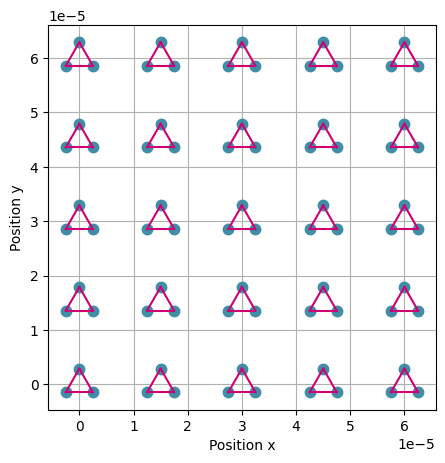

In [13]:
separation = 5e-6
block_separation = 15e-6
k_max = 5
m_max = 5

register = AtomArrangement()
for k in range(k_max):
    for m in range(m_max):
        register.add((block_separation*m, block_separation*k + separation/np.sqrt(3)))
        register.add((block_separation*m-separation/2, block_separation*k - separation/(2*np.sqrt(3))))
        register.add((block_separation*m+separation/2, block_separation*k - separation/(2*np.sqrt(3))))

show_register(register, show_atom_index=False, blockade_radius= 1.5 * separation)

## Create Driving Parameters

Aquila can simulate the following Hamiltonian 

\begin{align}
H(t) = \sum_{k=1}^N H_{\text{drive}, k}(t) + \sum_{j=1}^{N-1}\sum_{k = j+1}^N H_{\text{vdW}, j, k}.
\end{align}
Here the second term is the van der Waals interaction term which is fixed once the setup is defined. The first term is the driving field,
\begin{align}
H_{\text{drive}, k}(t) = \frac{\Omega(t)}{2}\left(e^{i\phi(t)}|g_k\rangle\langle r_k| + e^{-i\phi(t)}|r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t)n_k,
\end{align}
which act on all the atoms in the setup. Here $n_k = |r_k\rangle\langle r_k|$ is the number operator of atom $k$.  The specification of the driving field has to satisfy several conditions, which can be queried as follows

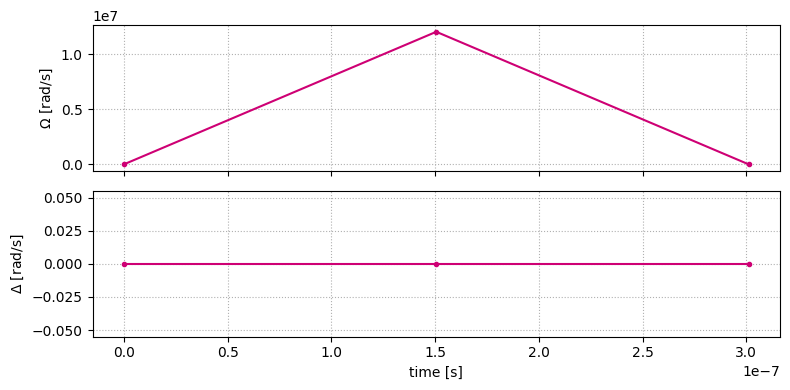

In [6]:
rydberg = device.properties.paradigm.rydberg
omega_const = 1.5e7   # rad / s
rabi_pulse_area = np.pi/np.sqrt(3) # rad
omega_slew_rate_max = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax) # rad/s^2

time_points, amplitude_values = rabi_pulse(rabi_pulse_area, omega_const, 0.2 * omega_slew_rate_max)

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = constant_time_series(amplitude, 0.0) 
phase = constant_time_series(amplitude, 0.0) 

drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)

show_global_drive(drive)

## Execute the Circuit

In [7]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)
discrete_program = ahs_program.discretize(device)

print("\n🤖 Executing Circuit...\n")

n_shots = 100
task = device.run(discrete_program, n_shots)

# At this point, the job is running on the Strangeworks Platform.
# You can check the status of the job in the Portal.
print(f"⏳ Job {task.id} submitted!\n")


🤖 Executing Circuit...

⏳ Job broken-bird-4263 submitted!



In [8]:
# task = StrangeworksQuantumTask.from_strangeworks_slug("")

result = task.result()

## Post-processing

In [9]:
n_shots = len(result.measurements)

counts = get_counts(result)
average_density = [0, 0, 0]
average_num_triangles = [0, 0, 0, 0]
for key, val in counts.items():
    for i in range(0, 3*k_max*m_max, 3):
        short_seq = key[i:i+3]
        for j in range(3):
            if short_seq[j]=="r":
                average_density[j] += val     
        
        
        average_num_triangles[short_seq.count('r')] += val
        
        
average_density = np.array(average_density) / (k_max * m_max * n_shots)
average_num_triangles = np.array(average_num_triangles) / n_shots

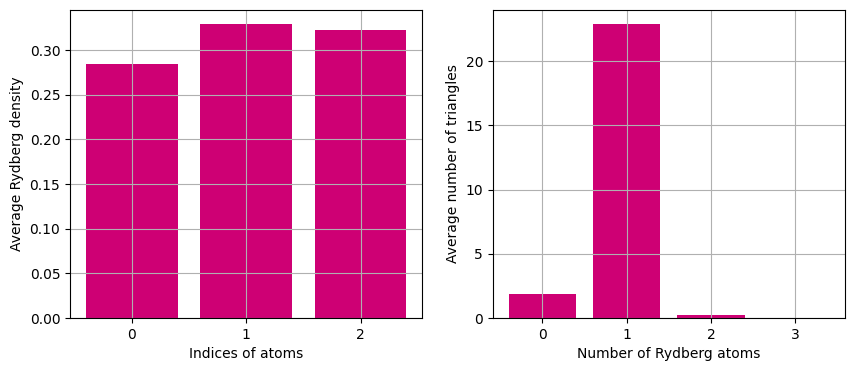

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.grid(True)
ax2.grid(True)

ax1.bar(range(len(average_density)), average_density, color = "#CE0074")
ax1.set_xticks(range(3))
ax1.set_xticklabels(range(3))
ax1.set_xlabel("Indices of atoms")
ax1.set_ylabel("Average Rydberg density")


ax2.bar(range(len(average_num_triangles)), average_num_triangles, color = "#CE0074")
ax2.set_xlabel("Number of Rydberg atoms")
ax2.set_ylabel("Average number of triangles")

plt.show()

In the left plot above we see that, on average, after simulation we have our atoms evenly distributed between each node of the triangles.

On the right, we see for each triangle, the average number of atoms in the excited Rydberg state. This shows that by the end of the simulation we mostly have 1 excitation per triangle, some triangles with no excitations and some with two. 